In [1]:
import sys
sys.path.append('../')

from common_imports import *
from common_functions import *

In [2]:
df = pd.read_csv("lookup.csv")
df, weather_features = preprocess_df(df)
sequence_length = 15

In [3]:
avant_2018 = df[(df['datetime'] < '2018-01-01')]
apres_2018 = df[(df['datetime'] >= '2018-01-01')]
cities = df['name'].unique()

In [4]:
infreq_df = infrequent_over_sample(avant_2018, cities)

In [19]:
def tt_split(cities, df, sequence_length, weather_features):
    all_X = []
    for city in cities:
        city_df = df[df['name'] == city]
        for i in range(len(city_df) - sequence_length):
            # Extract sequences of weather features
            weather_data = city_df[weather_features].iloc[i:i + sequence_length].values

            # Fire occurrence (binary)
            fire_label = city_df['FireOccurred'].iloc[i + sequence_length]

            # Fire severity (set to 0 if no fire occurred)
            severity_label = (
                city_df['OptimizedSeverityScore_Log'].iloc[i + sequence_length]
                if fire_label == 1 else 0
            )

            associated_date = city_df['datetime'].iloc[i + sequence_length]
            associated_city = city

            all_X.append({
                'city': associated_city,
                'datetime': associated_date,
                'weather_data': weather_data,
                'y_fire': fire_label,
                'y_severity': severity_label
            })
            
    # Convert unified data to DataFrame and numpy arrays
    all_X = pd.DataFrame(all_X)

    return all_X 

def grouped_tt_split(counties, df, sequence_length, weather_features):
    """
    Combine county grouping with centralized X DataFrame.
    Returns grouped data by county and a unified DataFrame for X.
    """
    all_X = []

    for county in counties:
        county_df = df[df['county'] == county]

        for i in range(len(county_df) - sequence_length):
            # Extract weather data sequence
            weather_data = county_df[weather_features].iloc[i:i + sequence_length].values

            # Fire occurrence (binary)
            fire_label = county_df['FireOccurred'].iloc[i + sequence_length]

            # Fire severity (set to 0 if no fire occurred)
            severity_label = (
                county_df['OptimizedSeverityScore_Log'].iloc[i + sequence_length]
                if fire_label == 1 else 0
            )

            associated_date = county_df['datetime'].iloc[i + sequence_length]
            associated_county = county

            # Append to unified lists
            all_X.append({
                'county': associated_county,
                'datetime': associated_date,
                'weather_data': weather_data,
                'y_fire': fire_label,
                'y_severity': severity_label
            })

    # Convert unified data to DataFrame and numpy arrays
    all_X = pd.DataFrame(all_X)

    return all_X 


def train_val_test(train_df, test_df, municipality, sequence_length, weather_features, grouped = False):
    # Validation and Test splits based on time
    validation = test_df[test_df['datetime'] < '2019-01-01']
    test = test_df[test_df['datetime'] >= '2019-01-01']
    
    if grouped == False:
        X_train = tt_split(municipality, train_df, sequence_length, weather_features)
        X_val = tt_split(municipality, validation, sequence_length, weather_features)
        X_test = tt_split(municipality, test, sequence_length, weather_features)
    else:
        X_train = grouped_tt_split(municipality, train_df, sequence_length, weather_features)
        X_val = grouped_tt_split(municipality, validation, sequence_length, weather_features)
        X_test = grouped_tt_split(municipality, test, sequence_length, weather_features)

    return (
        X_train,
        X_val,
        X_test
    )

In [23]:
X_train, X_val, X_test = train_val_test(infreq_df, apres_2018, cities, sequence_length, weather_features)

# Ensure fire labels are integers
X_train['y_fire'] = X_train['y_fire'].astype(int)
X_val['y_fire'] = X_val['y_fire'].astype(int)
X_test['y_fire'] = X_test['y_fire'].astype(int)

In [24]:
param_grid = {
    'lstm_units': [(64,), (64, 128), (128,), (32, 64), (32,), (32,64,128), (64,128, 256)],
    'dropout_rates': [0.2, 0.3, 0.4],
    'batch_norm': [True, False],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'reg_l2': [0.01, 0.001, 0.0001]
}

In [25]:
def setup_x_and_y(train, val):
    train_weather_features = np.stack(train['weather_data'].values)
    val_weather_features = np.stack(val['weather_data'].values)

    y_train_fire = np.stack(train['y_fire'].values)
    y_train_severity = np.stack(train['y_severity'].values)
    y_val_fire = np.stack(val['y_fire'].values)
    y_val_severity = np.stack(val['y_severity'].values)

    return train_weather_features, val_weather_features, y_train_fire, y_train_severity, y_val_fire, y_val_severity

In [26]:
from sklearn.model_selection import TimeSeriesSplit

def randomized_cv_search(X_train, X_val, counties, param_grid, n_iter=10, cv_folds=5):
    results = []

    # Setup features and labels
    train_weather_features, val_weather_features, y_train_fire, y_train_severity, y_val_fire, y_val_severity = setup_x_and_y(X_train, X_val)

    # Define TimeSeriesSplit iterator (don't shuffle data)
    tscv = TimeSeriesSplit(n_splits=cv_folds)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(train_weather_features)):
        # Split into training and validation for this fold
        fold_train_features = train_weather_features[train_idx]
        fold_val_features = train_weather_features[val_idx]
        fold_y_train_fire = y_train_fire[train_idx]
        fold_y_val_fire = y_train_fire[val_idx]
        fold_y_train_severity = y_train_severity[train_idx]
        fold_y_val_severity = y_train_severity[val_idx]

        for _ in range(n_iter):
            # Randomly sample hyperparameters
            params = {k: random.choice(v) for k, v in param_grid.items()}

            # Create and train the model
            model = create_lstm_model(
                sequence_length=fold_train_features.shape[1],
                weather_features=fold_train_features.shape[2],
                **params
            )

            try:
                model.fit(
                    x=fold_train_features,
                    y={'fire_output': fold_y_train_fire, 'severity_output': fold_y_train_severity},
                    validation_data=(fold_val_features, {'fire_output': fold_y_val_fire, 'severity_output': fold_y_val_severity}),
                    epochs=10,
                    batch_size=64,
                    verbose=2
                )

                # Evaluate the model
                eval_metrics = model.evaluate(
                    fold_val_features, 
                    {'fire_output': fold_y_val_fire, 'severity_output': fold_y_val_severity},
                    verbose=0
                )

                # Dynamically extract all metrics based on the compiled model's outputs
                metric_names = model.metrics_names  # Retrieve the names of the metrics
                metrics_dict = {name: value for name, value in zip(metric_names, eval_metrics)}

                # Add to results, organizing metrics by task
                results.append({
                    'fold': fold,
                    'params': params,
                    'metrics': metrics_dict
                })

            except Exception as e:
                print(f"Error training or evaluating fold {fold}: {e}")
                continue

    return results


In [27]:
results = randomized_cv_search(X_train, X_val, cities, param_grid, n_iter=3, cv_folds=3)

Epoch 1/10
232/232 - 14s - 62ms/step - fire_output_accuracy: 0.6875 - fire_output_f1_score: 31.3454 - fire_output_loss: 0.4256 - loss: 4.8150 - severity_output_loss: 0.9973 - severity_output_mae: 1.3986 - val_fire_output_accuracy: 0.6344 - val_fire_output_f1_score: 21.5024 - val_fire_output_loss: 0.4452 - val_loss: 4.1917 - val_severity_output_loss: 0.5502 - val_severity_output_mae: 0.9921
Epoch 2/10
232/232 - 13s - 54ms/step - fire_output_accuracy: 0.7639 - fire_output_f1_score: 31.1359 - fire_output_loss: 0.3387 - loss: 4.0728 - severity_output_loss: 0.7165 - severity_output_mae: 1.1779 - val_fire_output_accuracy: 0.6646 - val_fire_output_f1_score: 24.3665 - val_fire_output_loss: 0.5092 - val_loss: 3.8341 - val_severity_output_loss: 0.4912 - val_severity_output_mae: 0.9558
Epoch 3/10
232/232 - 13s - 54ms/step - fire_output_accuracy: 0.7897 - fire_output_f1_score: 31.1302 - fire_output_loss: 0.3072 - loss: 3.5943 - severity_output_loss: 0.6194 - severity_output_mae: 1.0821 - val_fire_

In [28]:
best_results_loss = min(results, key=lambda x: x['metrics']['fire_output_loss'])
best_results_loss

{'fold': 1,
 'params': {'lstm_units': (128,),
  'dropout_rates': 0.2,
  'batch_norm': False,
  'learning_rate': 0.001,
  'reg_l2': 0.001},
 'metrics': {'loss': 0.7927553653717041,
  'compile_metrics': 0.3809572756290436,
  'fire_output_loss': 0.38322171568870544,
  'severity_output_loss': 0.8606019616127014}}

In [33]:
def model_performance_best_params(X_train, X_val, best_results, patience=10, threshold=0.8):
    """
    Train models for each county using the best parameters and return history and predictions.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    all_histories = []
    y_train_true_fire = []
    y_train_pred_fire = []
    y_val_true_fire = []
    y_val_pred_fire = []
    y_train_true_severity = []
    y_train_pred_severity = []
    y_val_true_severity = []
    y_val_pred_severity = []

    best_params = best_results['params']

    # Setup features and targets
    train_weather_features, val_weather_features, y_train_fire, y_train_severity, y_val_fire, y_val_severity = setup_x_and_y(X_train, X_val)

    # Create model with best parameters
    model = create_lstm_model(
        sequence_length=sequence_length, 
        weather_features=train_weather_features.shape[2],
        **best_params
    )

    # Correct the filepath formatting for ModelCheckpoint
    checkpoint_filepath = f'best_model_undersample.keras'
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss')

    # Train the model
    model_history = model.fit(
        x=train_weather_features,
        y={'fire_output': y_train_fire, 'severity_output': y_train_severity},
        validation_data=(
            val_weather_features,
            {'fire_output': y_val_fire, 'severity_output': y_val_severity}
        ),
        epochs=50,
        batch_size=64,
        callbacks=[early_stopping, model_checkpoint],
        verbose=0
    )

    # Store training history
    all_histories.append(model_history)
    
    # True values
    y_train_true_fire.append(y_train_fire)
    y_val_true_fire.append(y_val_fire)
    y_train_true_severity.append(y_train_severity)
    y_val_true_severity.append(y_val_severity)

    # Predict probabilities
    y_train_pred_fire_proba = model.predict(train_weather_features, verbose=0)['fire_output']
    y_val_pred_fire_proba = model.predict(val_weather_features, verbose=0)['fire_output']

    # Apply threshold for fire output
    y_train_pred_fire.append((y_train_pred_fire_proba > threshold).astype(int))
    y_val_pred_fire.append((y_val_pred_fire_proba > threshold).astype(int))

    # Predict severity output
    y_train_pred_severity.append(model.predict(train_weather_features, verbose=0)['severity_output'])
    y_val_pred_severity.append(model.predict(val_weather_features, verbose=0)['severity_output'])

    return all_histories, y_train_true_fire, y_train_pred_fire, y_val_true_fire, y_val_pred_fire, y_train_true_severity, y_train_pred_severity, y_val_true_severity, y_val_pred_severity


In [34]:
histories, train_true_fire, train_pred_fire, val_true_fire, val_pred_fire, train_true_severity, train_pred_severity, val_true_severity, val_pred_severity = model_performance_best_params(
    X_train, X_val, best_results_loss, patience=10, threshold=0.8
)

In [37]:
len(histories)

1

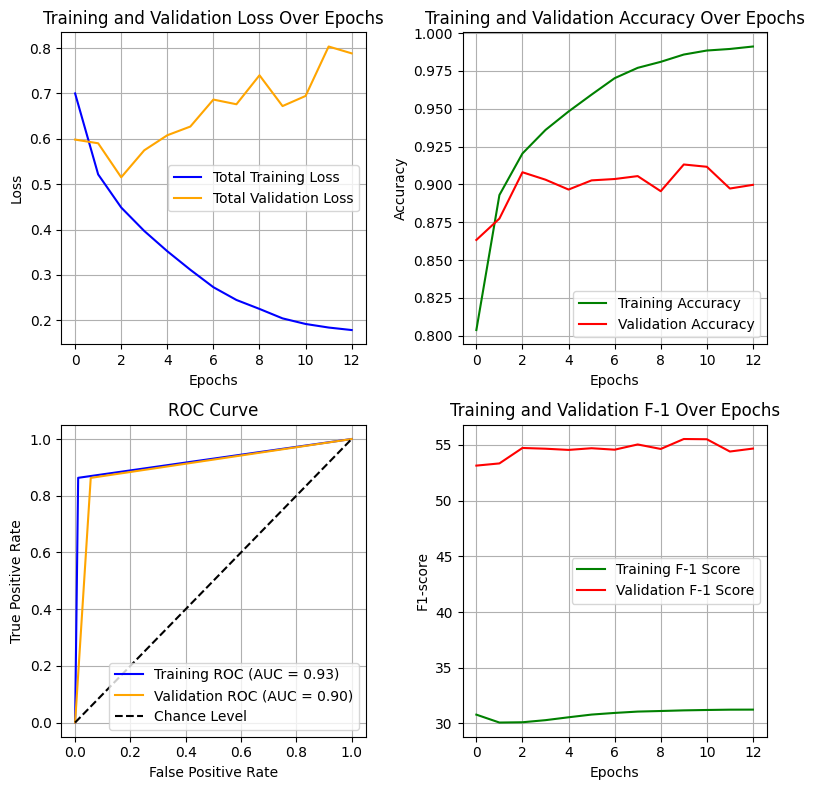

In [40]:
single_history = histories[0]  # Extract the single history object
plot_performance(
    single_history,  # Pass the `.history` attribute directly
    y_train_true=train_true_fire[0],
    y_train_pred_proba=train_pred_fire[0],
    y_val_true=val_true_fire[0],
    y_val_pred_proba=val_pred_fire[0]
)

In [ ]:
interm_model = LSTM_model(sequence_length, weather_features, lstm_units=[128,], dropout_rates=[0.2], batch_norm=False, reg_l2=0.001)
interm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'fire_output': weighted_binary_crossentropy,
        'severity_output': 'mse'
    },
    metrics={
        'fire_output': [f1_score, 'accuracy'],
        'severity_output': ['mae']
    },
    loss_weights={'fire_output': 0.7, 'severity_output': 0.3}
)

interm_history, y_train_pred_proba_fire, y_val_pred_proba_fire, y_train_pred_proba_severity, y_val_pred_proba_severity = model_performance(
    X_train_array, y_train_fire, y_train_severity, 
    X_val_array, y_val_fire, y_val_severity, interm_model
)

plot_performance(
    interm_history, 
    y_train_true=y_train_fire, 
    y_train_pred_proba=y_train_pred_proba_fire,
    y_val_true=y_val_fire, 
    y_val_pred_proba=y_val_pred_proba_fire
)

In [34]:
def weighted_binary_crossentropy(y_true, y_pred):
    print(str(y_pred))
    y_true = tf.cast(y_true, tf.float32)

    # Count occurrences in the batch
    num_occurred = tf.reduce_sum(y_true)
    num_non_occurred = tf.size(y_true) - num_occurred

    # Assign weights dynamically
    weight_occurred = tf.cond(num_non_occurred > num_occurred, lambda: 2.0, lambda: 1.0)
    weight_non_occurred = tf.cond(num_occurred > num_non_occurred, lambda: 2.0, lambda: 1.0)

    weights = tf.where(y_true == 1, weight_occurred, weight_non_occurred)
    return tf.reduce_mean(weights * tf.keras.losses.binary_crossentropy(y_true, y_pred))

Epoch 1/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - fire_output_accuracy: 0.7126 - fire_output_f1_score: 31.1223 - fire_output_loss: 0.5628 - loss: 1.6418 - severity_output_loss: 0.4968 - severity_output_mae: 0.9109 - val_fire_output_accuracy: 0.7946 - val_fire_output_f1_score: 49.7079 - val_fire_output_loss: 0.5139 - val_loss: 1.0284 - val_severity_output_loss: 0.4426 - val_severity_output_mae: 0.8574
Epoch 2/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - fire_output_accuracy: 0.8349 - fire_output_f1_score: 30.1118 - fire_output_loss: 0.3856 - loss: 0.8236 - severity_output_loss: 0.3646 - severity_output_mae: 0.7285 - val_fire_output_accuracy: 0.8620 - val_fire_output_f1_score: 53.1305 - val_fire_output_loss: 0.3875 - val_loss: 0.8474 - val_severity_output_loss: 0.3895 - val_severity_output_mae: 0.7751
Epoch 3/10
925/925 ━━━━━━━━━━━━━━━━━━━━ 43s 46ms/step - fire_output_accuracy: 0.8785 - fire_output_f1_score: 30.1165 - fire_output_loss: 0.3128 - loss: 0.7076 - severity_output_los

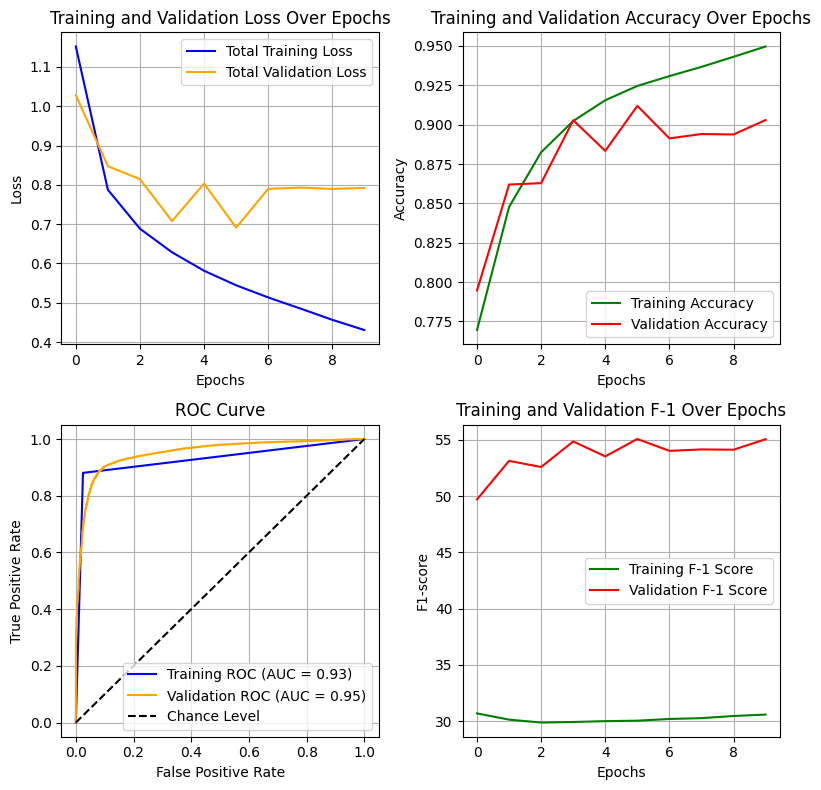

In [7]:
interm_model = LSTM_model(sequence_length, weather_features, lstm_units=[128, 256], dropout_rates=[0.3, 0.4], reg_l2=0.01)
interm_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss={
        'fire_output': weighted_binary_crossentropy,
        'severity_output': 'mse'
    },
    metrics={
        'fire_output': [f1_score, 'accuracy'],
        'severity_output': ['mae']
    },
    loss_weights={'fire_output': 0.7, 'severity_output': 0.3}
)

interm_history, y_train_pred_proba_fire, y_val_pred_proba_fire, y_train_pred_proba_severity, y_val_pred_proba_severity = model_performance(
    X_train_array, y_train_fire, y_train_severity, 
    X_val_array, y_val_fire, y_val_severity, interm_model
)

plot_performance(
    interm_history, 
    y_train_true=y_train_fire, 
    y_train_pred_proba=y_train_pred_proba_fire,
    y_val_true=y_val_fire, 
    y_val_pred_proba=y_val_pred_proba_fire
)

298/298 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
    datetime         city  FirePrediction  FireTrue  SeverityPrediction  \
0 2019-04-16  Alturas, CA               0         0                 0.0   
1 2019-04-17  Alturas, CA               0         0                 0.0   
2 2019-04-18  Alturas, CA               0         0                 0.0   
3 2019-04-19  Alturas, CA               0         0                 0.0   
4 2019-04-20  Alturas, CA               0         0                 0.0   

   SeverityTrue  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
[[4693 3818]
 [ 385  636]]


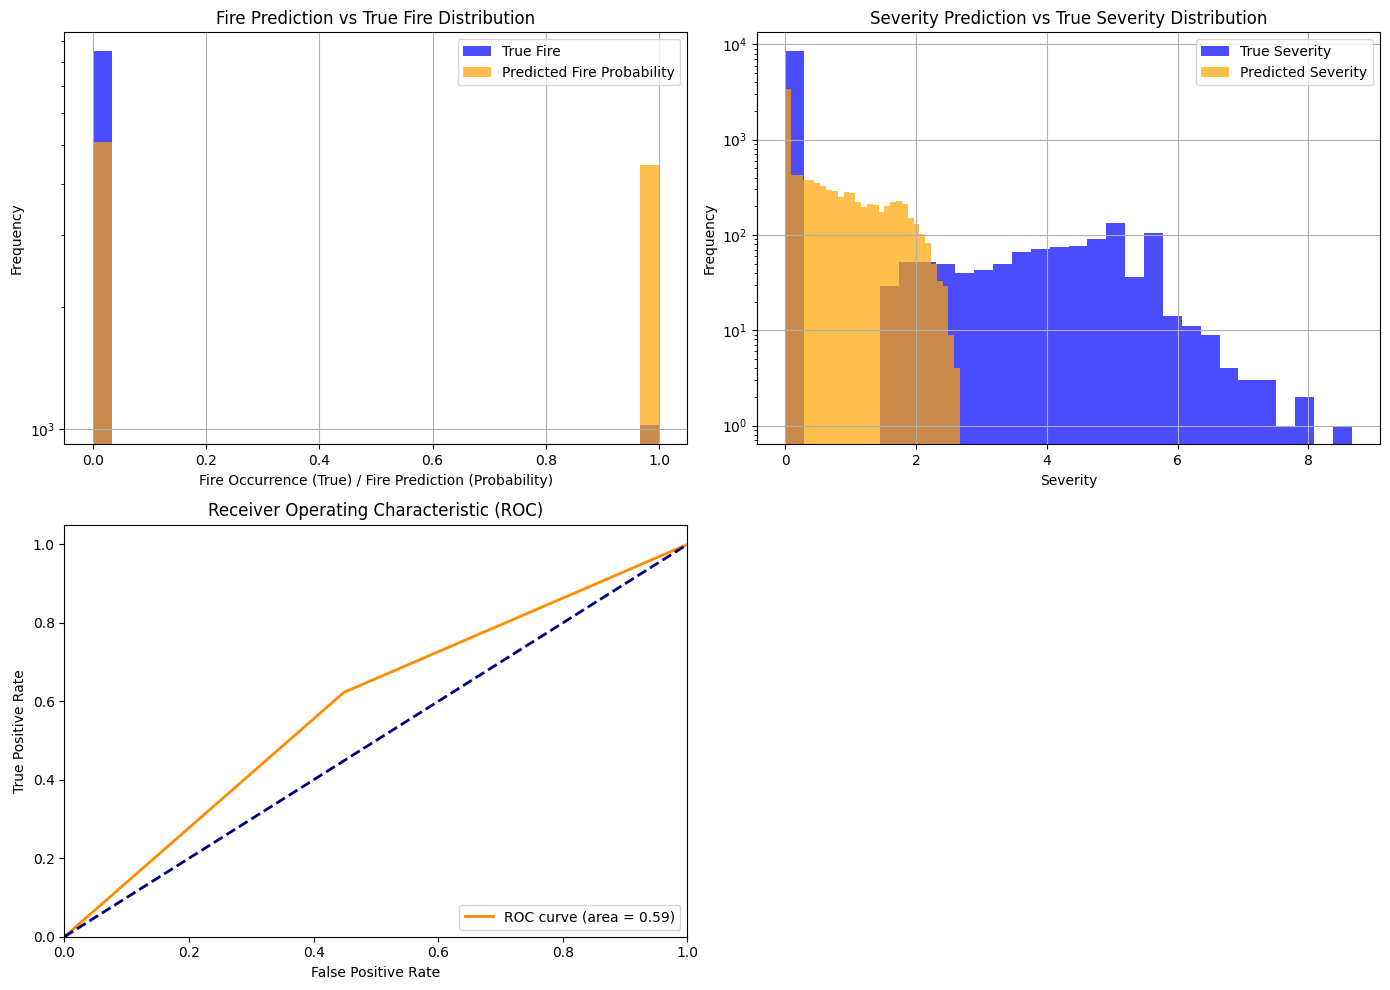

In [8]:
results_df = predict_wildfire(X_test, y_test_fire, y_test_severity, interm_model)
plot_result_df(results_df)

Epoch 1/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - fire_output_accuracy: 0.7311 - fire_output_f1_score: 32.2053 - fire_output_loss: 0.3676 - loss: 0.9184 - severity_output_loss: 0.4637 - severity_output_mae: 0.8862 - val_fire_output_accuracy: 0.8832 - val_fire_output_f1_score: 54.7408 - val_fire_output_loss: 0.2025 - val_loss: 0.5452 - val_severity_output_loss: 0.3075 - val_severity_output_mae: 0.6883
Epoch 2/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 34s 49ms/step - fire_output_accuracy: 0.8732 - fire_output_f1_score: 30.9586 - fire_output_loss: 0.2182 - loss: 0.5657 - severity_output_loss: 0.3116 - severity_output_mae: 0.6585 - val_fire_output_accuracy: 0.8738 - val_fire_output_f1_score: 53.9888 - val_fire_output_loss: 0.1905 - val_loss: 0.5490 - val_severity_output_loss: 0.3267 - val_severity_output_mae: 0.7530
Epoch 3/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 33s 48ms/step - fire_output_accuracy: 0.9123 - fire_output_f1_score: 30.7724 - fire_output_loss: 0.1674 - loss: 0.4800 - severity_output_los

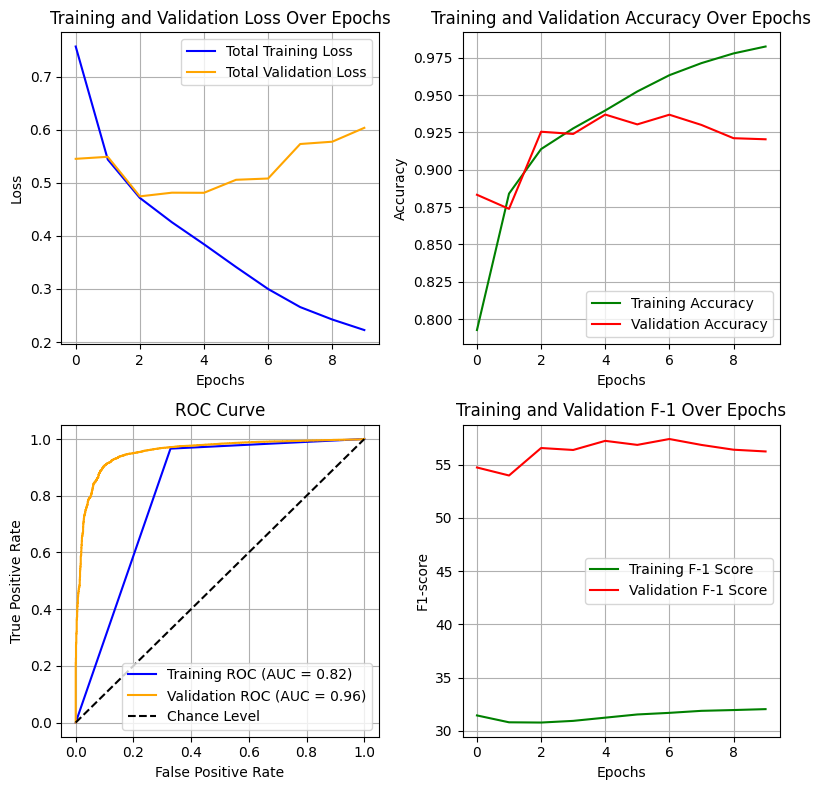

In [6]:
interm_model = LSTM_model(sequence_length, weather_features, lstm_units=[128, 256], dropout_rates=[0.3, 0.4], reg_l2=0.001)
interm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'fire_output': 'binary_crossentropy',
        'severity_output': 'mse'
    },
    metrics={
        'fire_output': [f1_score, 'accuracy'],
        'severity_output': ['mae']
    },
    loss_weights={'fire_output': 0.7, 'severity_output': 0.3}
)

interm_history, y_train_pred_proba_fire, y_val_pred_proba_fire, y_train_pred_proba_severity, y_val_pred_proba_severity = model_performance(
    X_train_array, y_train_fire, y_train_severity, 
    X_val_array, y_val_fire, y_val_severity, interm_model
)

plot_performance(
    interm_history, 
    y_train_true=y_train_fire, 
    y_train_pred_proba=y_train_pred_proba_fire,
    y_val_true=y_val_fire, 
    y_val_pred_proba=y_val_pred_proba_fire
)

228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
    datetime         city  FirePrediction  FireTrue  SeverityPrediction  \
0 2019-04-16  Antioch, CA               0         0                 0.0   
1 2019-04-17  Antioch, CA               0         0                 0.0   
2 2019-04-18  Antioch, CA               0         0                 0.0   
3 2019-04-19  Antioch, CA               0         0                 0.0   
4 2019-04-20  Antioch, CA               0         0                 0.0   

   SeverityTrue  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
[[5592  714]
 [ 728  237]]


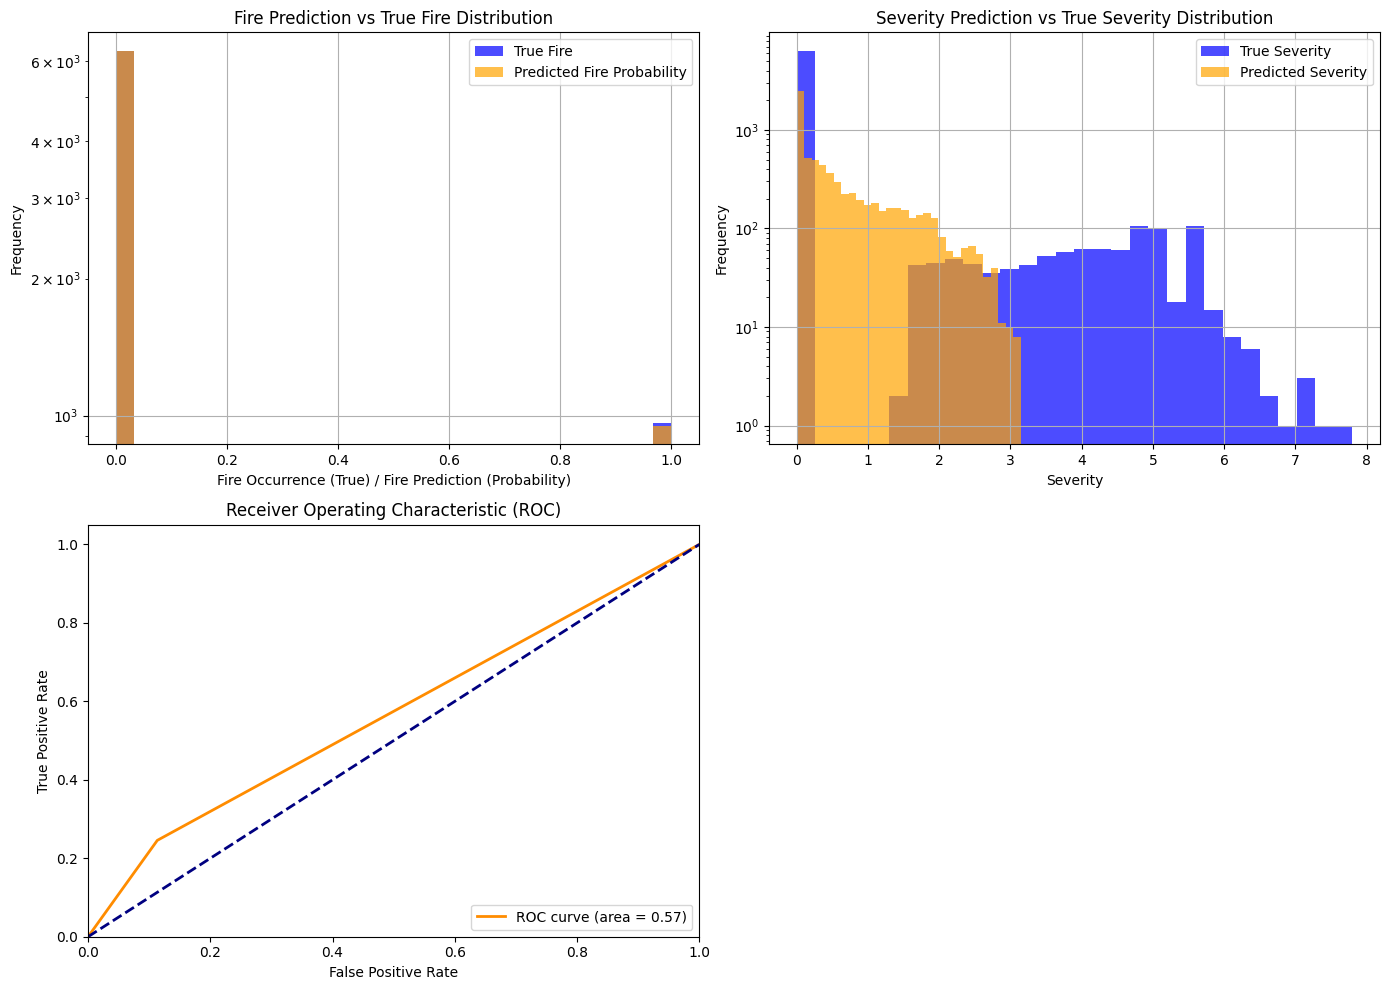

In [21]:
results_df = predict_wildfire(X_test, y_test_fire, y_test_severity, interm_model, threshold=0.8)
plot_result_df(results_df)

Epoch 1/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 40s 56ms/step - fire_output_accuracy: 0.6685 - fire_output_f1_score: 31.6636 - fire_output_loss: 0.4142 - loss: 1.9148 - severity_output_loss: 0.5124 - severity_output_mae: 0.9903 - val_fire_output_accuracy: 0.7933 - val_fire_output_f1_score: 50.7406 - val_fire_output_loss: 0.2899 - val_loss: 0.7992 - val_severity_output_loss: 0.4240 - val_severity_output_mae: 0.8222
Epoch 2/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - fire_output_accuracy: 0.8094 - fire_output_f1_score: 31.1721 - fire_output_loss: 0.2944 - loss: 0.7512 - severity_output_loss: 0.3738 - severity_output_mae: 0.7770 - val_fire_output_accuracy: 0.8810 - val_fire_output_f1_score: 54.9709 - val_fire_output_loss: 0.1990 - val_loss: 0.5999 - val_severity_output_loss: 0.3278 - val_severity_output_mae: 0.7125
Epoch 3/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - fire_output_accuracy: 0.8433 - fire_output_f1_score: 30.8198 - fire_output_loss: 0.2567 - loss: 0.6745 - severity_output_los

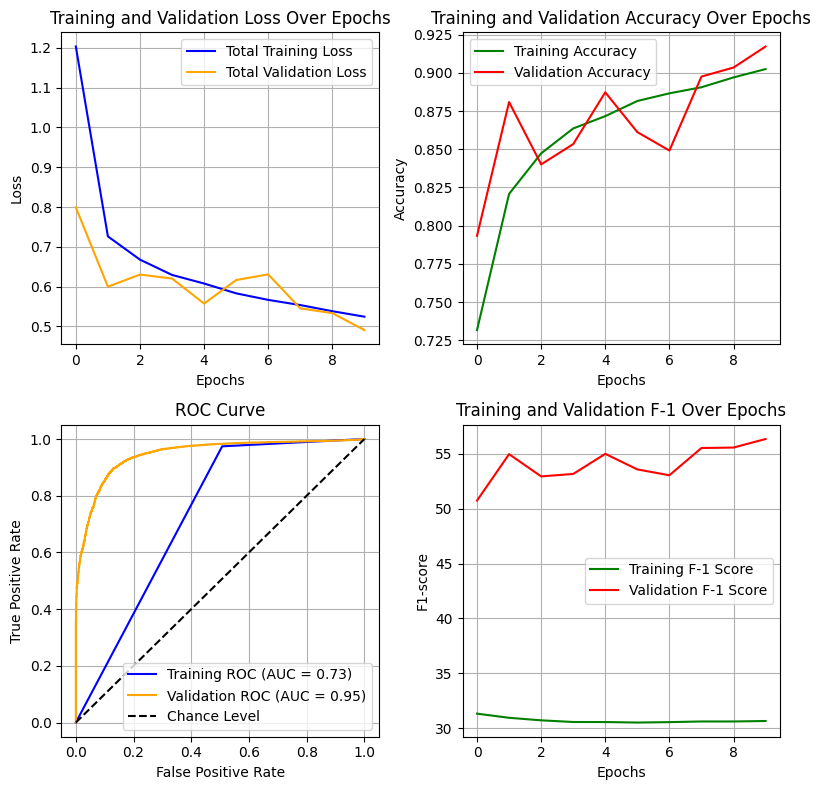

In [22]:
interm_model = LSTM_model(sequence_length, weather_features, lstm_units=[64, 128, 256], dropout_rates=[0.4, 0.4, 0.4], reg_l2=0.01)
interm_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss={
        'fire_output': 'binary_crossentropy',
        'severity_output': 'mse'
    },
    metrics={
        'fire_output': [f1_score, 'accuracy'],
        'severity_output': ['mae']
    },
    loss_weights={'fire_output': 0.7, 'severity_output': 0.3}
)

interm_history, y_train_pred_proba_fire, y_val_pred_proba_fire, y_train_pred_proba_severity, y_val_pred_proba_severity = model_performance(
    X_train_array, y_train_fire, y_train_severity, 
    X_val_array, y_val_fire, y_val_severity, interm_model
)

plot_performance(
    interm_history, 
    y_train_true=y_train_fire, 
    y_train_pred_proba=y_train_pred_proba_fire,
    y_val_true=y_val_fire, 
    y_val_pred_proba=y_val_pred_proba_fire
)

228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step
    datetime         city  FirePrediction  FireTrue  SeverityPrediction  \
0 2019-04-16  Antioch, CA               0         0            0.091976   
1 2019-04-17  Antioch, CA               0         0            0.041914   
2 2019-04-18  Antioch, CA               0         0            0.000000   
3 2019-04-19  Antioch, CA               0         0            0.000000   
4 2019-04-20  Antioch, CA               0         0            0.000000   

   SeverityTrue  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
[[5341  965]
 [ 707  258]]


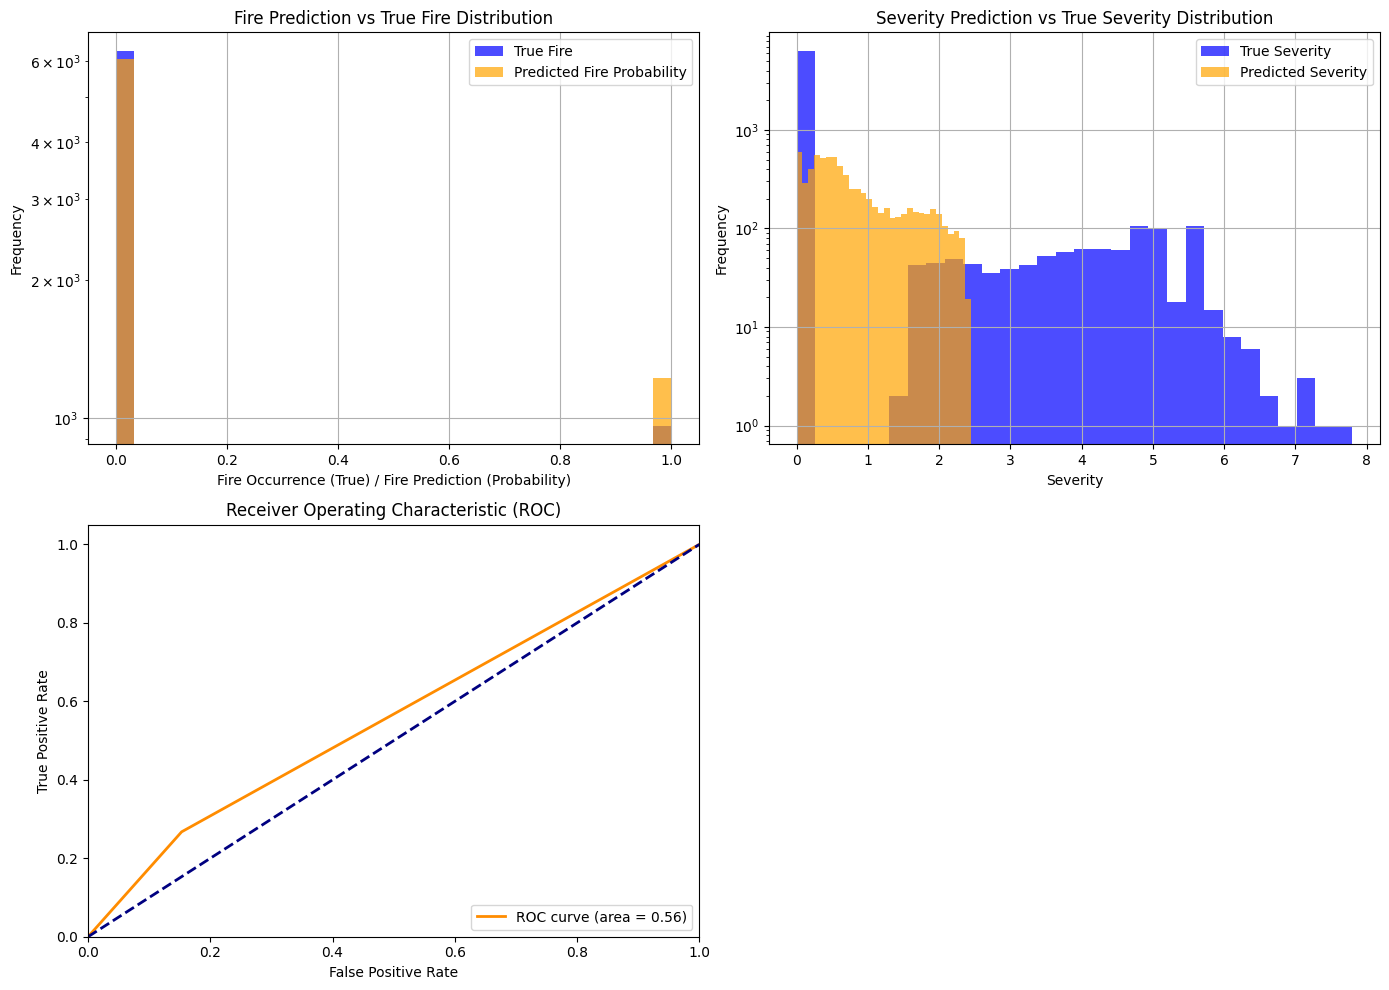

In [23]:
results_df = predict_wildfire(X_test, y_test_fire, y_test_severity, interm_model, threshold=0.80)
plot_result_df(results_df)

Sliding Window

In [29]:
sliding_window_sampled_df = sliding_over_sample(avant_2018, cities)

In [30]:
X_train, y_train_fire, y_train_severity, X_val, y_val_fire, y_val_severity, X_test, y_test_fire, y_test_severity = train_val_test(sliding_window_sampled_df, apres_2018, cities, sequence_length, weather_features)

Epoch 1/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - fire_output_accuracy: 0.6159 - fire_output_f1_score: 32.6286 - fire_output_loss: 0.4502 - loss: 4.6816 - severity_output_loss: 0.5261 - severity_output_mae: 1.0343 - val_fire_output_accuracy: 0.7987 - val_fire_output_f1_score: 51.3891 - val_fire_output_loss: 0.2775 - val_loss: 0.7451 - val_severity_output_loss: 0.4136 - val_severity_output_mae: 0.8505
Epoch 2/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - fire_output_accuracy: 0.7393 - fire_output_f1_score: 30.3966 - fire_output_loss: 0.3685 - loss: 0.8340 - severity_output_loss: 0.4150 - severity_output_mae: 0.9020 - val_fire_output_accuracy: 0.7411 - val_fire_output_f1_score: 47.9907 - val_fire_output_loss: 0.3323 - val_loss: 0.8519 - val_severity_output_loss: 0.4759 - val_severity_output_mae: 0.9044
Epoch 3/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - fire_output_accuracy: 0.7512 - fire_output_f1_score: 30.2698 - fire_output_loss: 0.3532 - loss: 0.7990 - severity_output_los

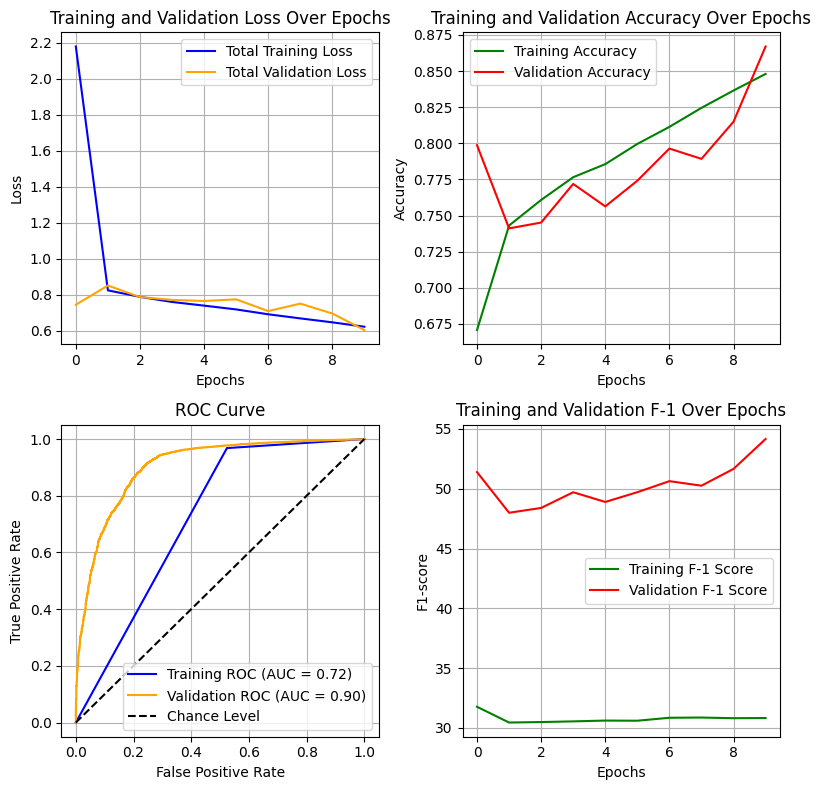

In [31]:
interm_model = LSTM_model(sequence_length, weather_features, lstm_units=[64, 128], dropout_rates=[0.4, 0.4], reg_l2=0.1)
interm_model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss={
        'fire_output': 'binary_crossentropy',
        'severity_output': 'mse'
    },
    metrics={
        'fire_output': [f1_score, 'accuracy'],
        'severity_output': ['mae']
    },
    loss_weights={'fire_output': 0.7, 'severity_output': 0.3}
)

interm_history, y_train_pred_proba_fire, y_val_pred_proba_fire, y_train_pred_proba_severity, y_val_pred_proba_severity = model_performance(
    X_train_array, y_train_fire, y_train_severity, 
    X_val_array, y_val_fire, y_val_severity, interm_model
)

plot_performance(
    interm_history, 
    y_train_true=y_train_fire, 
    y_train_pred_proba=y_train_pred_proba_fire,
    y_val_true=y_val_fire, 
    y_val_pred_proba=y_val_pred_proba_fire
)

228/228 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
    datetime         city  FirePrediction  FireTrue  SeverityPrediction  \
0 2019-04-16  Antioch, CA               0         0            0.284848   
1 2019-04-17  Antioch, CA               0         0            0.073150   
2 2019-04-18  Antioch, CA               0         0            0.000000   
3 2019-04-19  Antioch, CA               0         0            0.000000   
4 2019-04-20  Antioch, CA               0         0            0.000000   

   SeverityTrue  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  


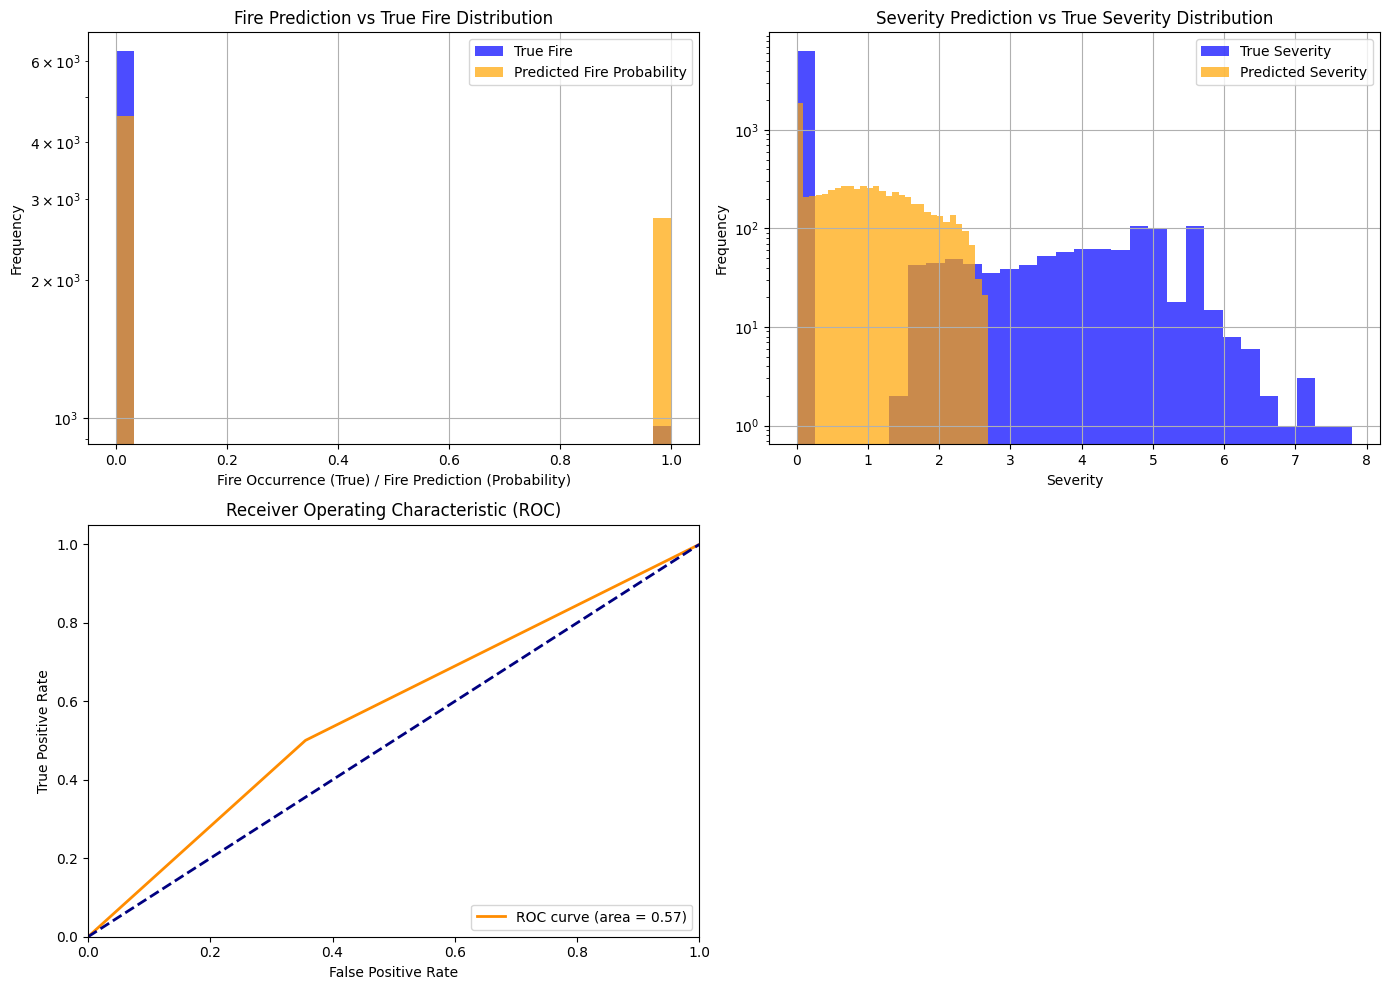

In [32]:
results_df = predict_wildfire(X_test, y_test_fire, y_test_severity, interm_model)
plot_result_df(results_df)

Epoch 1/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - fire_output_accuracy: 0.6287 - fire_output_f1_score: 33.5166 - fire_output_loss: 0.9493 - loss: 11.3447 - severity_output_loss: 1.6889 - severity_output_mae: 1.0308 - val_fire_output_accuracy: 0.7359 - val_fire_output_f1_score: 47.5801 - val_fire_output_loss: 0.9041 - val_loss: 2.6593 - val_severity_output_loss: 1.5604 - val_severity_output_mae: 0.9056
Epoch 2/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 38s 56ms/step - fire_output_accuracy: 0.7669 - fire_output_f1_score: 30.8622 - fire_output_loss: 0.7344 - loss: 2.2298 - severity_output_loss: 1.2998 - severity_output_mae: 0.8504 - val_fire_output_accuracy: 0.7301 - val_fire_output_f1_score: 47.1988 - val_fire_output_loss: 0.9583 - val_loss: 2.4952 - val_severity_output_loss: 1.3542 - val_severity_output_mae: 0.8320
Epoch 3/10
679/679 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - fire_output_accuracy: 0.8009 - fire_output_f1_score: 30.8129 - fire_output_loss: 0.6571 - loss: 2.0594 - severity_output_lo

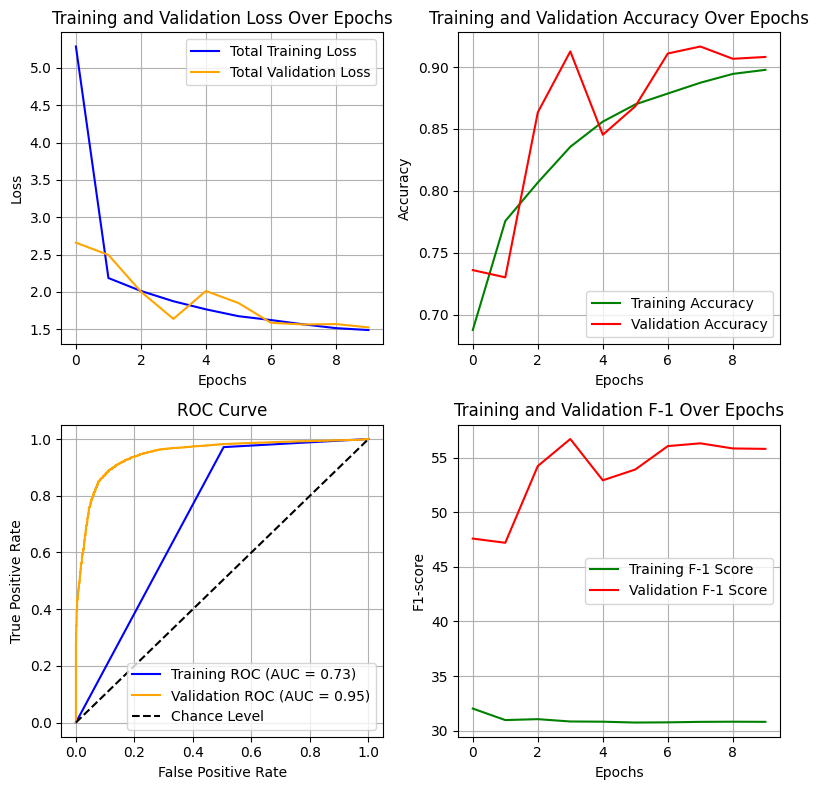

In [33]:
interm_model = LSTM_model(sequence_length, weather_features, lstm_units=[64, 128, 256], dropout_rates=[0.4, 0.4, 0.4], reg_l2=0.1)
interm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0005),
    loss={'fire_output': weighted_binary_crossentropy, 'severity_output': 'mse'},
    metrics={
        'fire_output': [f1_score, 'accuracy'],
        'severity_output': 'mae'
    }
)

interm_history, y_train_pred_proba_fire, y_val_pred_proba_fire, y_train_pred_proba_severity, y_val_pred_proba_severity = model_performance(
    X_train_array, y_train_fire, y_train_severity, 
    X_val_array, y_val_fire, y_val_severity, interm_model
)

plot_performance(
    interm_history, 
    y_train_true=y_train_fire, 
    y_train_pred_proba=y_train_pred_proba_fire,
    y_val_true=y_val_fire, 
    y_val_pred_proba=y_val_pred_proba_fire
)

228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
    datetime         city  FirePrediction  FireTrue  SeverityPrediction  \
0 2019-04-16  Antioch, CA               0         0            0.000000   
1 2019-04-17  Antioch, CA               0         0            0.000000   
2 2019-04-18  Antioch, CA               0         0            0.035449   
3 2019-04-19  Antioch, CA               0         0            0.157010   
4 2019-04-20  Antioch, CA               0         0            0.161218   

   SeverityTrue  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  


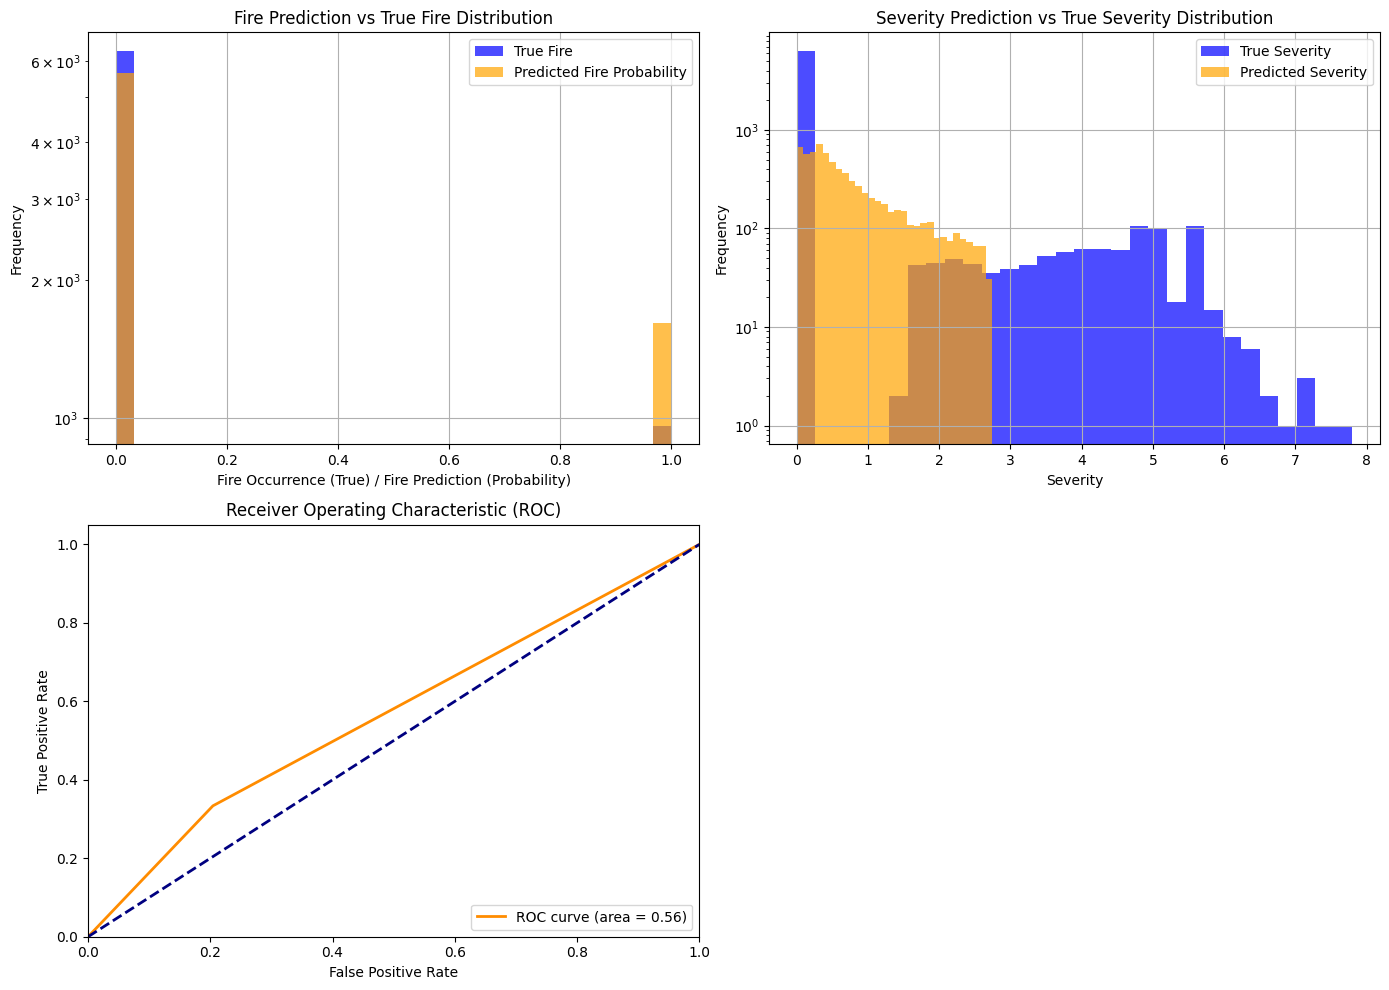

In [34]:
results_df = predict_wildfire(X_test, y_test_fire, y_test_severity, interm_model)
plot_result_df(results_df)

Epoch 1/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 43s 60ms/step - fire_output_accuracy: 0.6141 - fire_output_f1_score: 32.2729 - fire_output_loss: 0.9695 - loss: 8.2870 - severity_output_loss: 1.7313 - severity_output_mae: 1.0549 - val_fire_output_accuracy: 0.9086 - val_fire_output_f1_score: 55.7688 - val_fire_output_loss: 0.4669 - val_loss: 1.7572 - val_severity_output_loss: 1.1284 - val_severity_output_mae: 0.7508
Epoch 2/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - fire_output_accuracy: 0.8607 - fire_output_f1_score: 31.2929 - fire_output_loss: 0.5312 - loss: 1.7704 - severity_output_loss: 1.0756 - severity_output_mae: 0.6700 - val_fire_output_accuracy: 0.9264 - val_fire_output_f1_score: 56.4550 - val_fire_output_loss: 0.2944 - val_loss: 1.4735 - val_severity_output_loss: 1.0465 - val_severity_output_mae: 0.7123
Epoch 3/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 43s 63ms/step - fire_output_accuracy: 0.8951 - fire_output_f1_score: 30.3076 - fire_output_loss: 0.4266 - loss: 1.5567 - severity_output_los

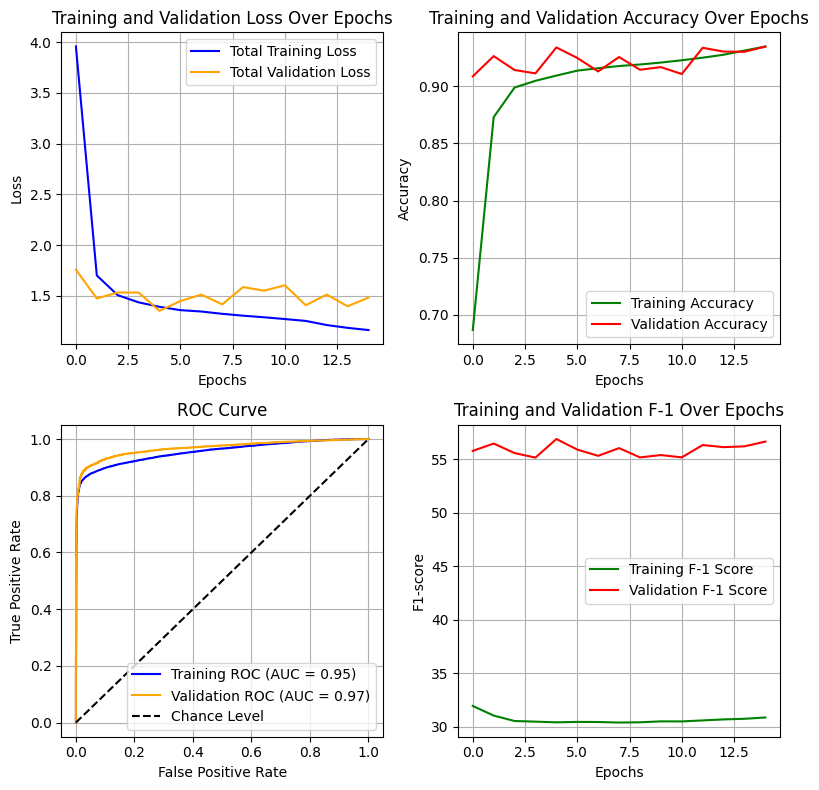

In [13]:
interm_model = GRU_model(sequence_length, weather_features, lstm_units=[64, 128, 256], dropout_rates=[0.4, 0.4, 0.4], reg_l2=0.1)
interm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
    loss={'fire_output': weighted_binary_crossentropy, 'severity_output': 'mse'},
    metrics={
        'fire_output': [f1_score, 'accuracy'],
        'severity_output': 'mae'
    }
)

interm_history, y_train_pred_proba, y_val_pred_proba = model_performance(
    X_train, y_train_fire, y_train_severity, 
    X_val, y_val_fire, y_val_severity, interm_model
)

plot_performance(
    interm_history, 
    y_train_true=y_train_fire, 
    y_train_pred_proba=y_train_pred_proba,
    y_val_true=y_val_fire, 
    y_val_pred_proba=y_val_pred_proba
)

Epoch 1/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - fire_output_accuracy: 0.6265 - fire_output_f1_score: 32.1569 - fire_output_loss: 0.9418 - loss: 5.3755 - severity_output_loss: 1.7589 - severity_output_mae: 1.0442 - val_fire_output_accuracy: 0.9179 - val_fire_output_f1_score: 56.2378 - val_fire_output_loss: 0.3606 - val_loss: 1.6287 - val_severity_output_loss: 1.0951 - val_severity_output_mae: 0.6872
Epoch 2/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - fire_output_accuracy: 0.8716 - fire_output_f1_score: 31.0894 - fire_output_loss: 0.4900 - loss: 1.6783 - severity_output_loss: 1.0203 - severity_output_mae: 0.6307 - val_fire_output_accuracy: 0.9169 - val_fire_output_f1_score: 55.7240 - val_fire_output_loss: 0.3318 - val_loss: 1.5042 - val_severity_output_loss: 1.0368 - val_severity_output_mae: 0.7564
Epoch 3/20
679/679 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - fire_output_accuracy: 0.9019 - fire_output_f1_score: 30.5100 - fire_output_loss: 0.4072 - loss: 1.4594 - severity_output_los

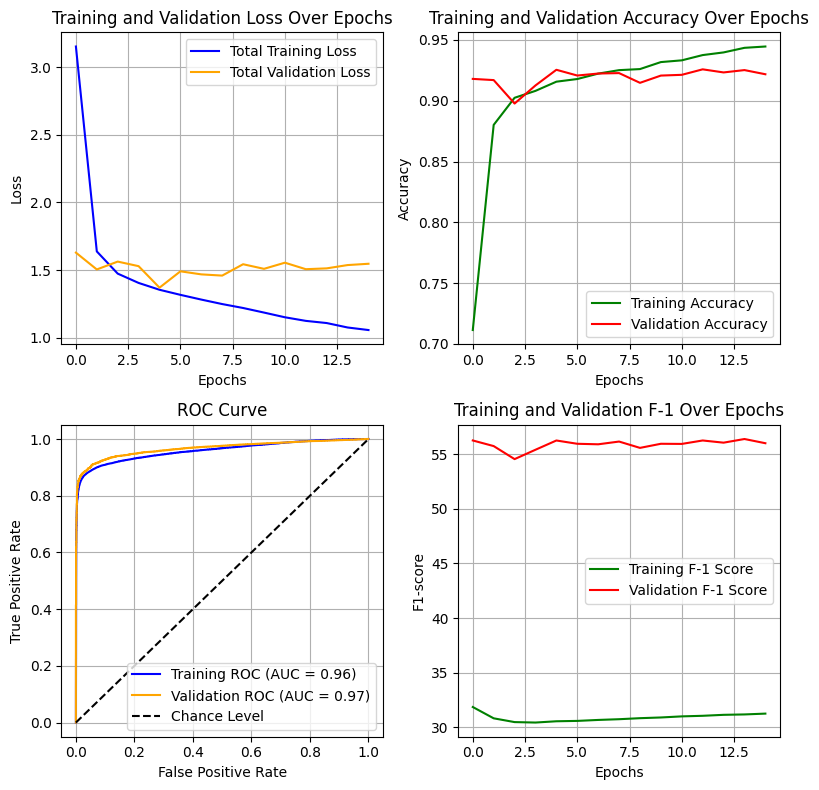

In [14]:
interm_model = GRU_model(sequence_length, weather_features, lstm_units=[64, 128], dropout_rates=[0.4, 0.4], reg_l2=0.1)
interm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001),
    loss={'fire_output': weighted_binary_crossentropy, 'severity_output': 'mse'},
    metrics={
        'fire_output': [f1_score, 'accuracy'],
        'severity_output': 'mae'
    }
)

interm_history, y_train_pred_proba, y_val_pred_proba = model_performance(
    X_train, y_train_fire, y_train_severity, 
    X_val, y_val_fire, y_val_severity, interm_model
)

plot_performance(
    interm_history, 
    y_train_true=y_train_fire, 
    y_train_pred_proba=y_train_pred_proba,
    y_val_true=y_val_fire, 
    y_val_pred_proba=y_val_pred_proba
)

In [12]:
def predict_wildfire(test, model, sequence_length):
    test['datetime'] = pd.to_datetime(test['datetime'])  # Convert 'date' column to datetime if not already
    test.sort_values(by=['name', 'datetime'], inplace=True)

    scaler = StandardScaler()
    weather_features = ["temp", "dew", "precip"
                        "windspeed","winddir","sealevelpressure",
                        "cloudcover","solarradiation"]

    test[weather_features] = scaler.fit_transform(test[weather_features])

    dates = test['datetime']

    X_pred = []
    seq_dates = [] 
    for i in range(len(test) - sequence_length + 1):
        sequence = test.iloc[i:i + sequence_length].values
        X_pred.append(test[weather_features].iloc[i:i + sequence_length].values)

    X_pred = np.array(X_pred)

    for i in range(len(test) - sequence_length + 1):
        seq_dates.append(dates.iloc[i + sequence_length - 1]) 

    predictions = model.predict(X_pred)
    fire_likelihood = predictions['fire_output']  # Probabilities
    severity_prediction = predictions['severity_output']  # Severity scores

    results = pd.DataFrame({
    'date': seq_dates,
    'fire_likelihood': fire_likelihood.flatten(),
    'predicted_severity': severity_prediction.flatten()
    })

    return(results)

In [20]:
X_val

array([[[-0.81740231, -0.01380955, -0.13344592, ..., -0.32704456,
         -0.81013489,  0.18320004],
        [-0.81740231, -0.01380955, -0.13344592, ..., -0.65957957,
         -0.80274462,  0.01807302],
        [-0.88515306, -0.33812892, -0.13344592, ...,  0.14404672,
         -0.81013489,  0.08847601],
        ...,
        [-1.24084452, -0.61123998, -0.13344592, ...,  3.94048816,
         -0.81013489,  0.29584482],
        [-0.78352693, -0.2015734 , -0.13344592, ...,  2.69348185,
         -0.81013489,  0.29328471],
        [-1.24084452, -0.21864284,  0.40239527, ...,  0.19946922,
          0.08778375,  0.0551946 ]],

       [[-0.81740231, -0.01380955, -0.13344592, ..., -0.65957957,
         -0.80274462,  0.01807302],
        [-0.88515306, -0.33812892, -0.13344592, ...,  0.14404672,
         -0.81013489,  0.08847601],
        [-0.93596613, -0.30399004, -0.13344592, ...,  0.80911675,
         -0.27803496, -0.24689824],
        ...,
        [-0.78352693, -0.2015734 , -0.13344592, ...,  

In [19]:
X_test

[array([[-1.05452995, -0.06501787,  0.35292719, -1.45988021,  0.7774516 ,
          0.36573673,  1.07069058, -1.87256731],
        [-1.1222807 ,  0.19102374,  0.18450917,  1.10945424, -0.08617612,
         -0.52102332,  1.97969464, -1.34774501],
        [-1.15615608,  0.12274598,  0.01420306, -0.90067212, -0.07461483,
          0.67056049,  1.96491409, -2.01209324],
        [-1.07146763,  0.03739877, -0.13344592,  0.3839951 , -0.23531665,
          0.61513799,  1.79493772, -1.65879823],
        [-1.24084452,  0.02032933,  0.4091924 , -0.4623739 , -0.48850871,
          0.53200424,  1.67669329, -2.2041014 ],
        [-0.93596613,  0.20809318, -0.13344592,  0.59558735, -0.11161094,
          1.44647553,  1.48824123, -1.28758245],
        [-0.54639929,  0.51534312, -0.13344592,  0.20263031,  0.11961469,
          2.80432685,  0.47577329, -0.04208954],
        [-0.56333698,  0.66896809, -0.13344592,  0.95831692, -0.07577096,
          2.27781307,  0.52381009, -1.45526958],
        [-0.9529

In [13]:
predict_wildfire(X_test, interm_model, sequence_length)

TypeError: list indices must be integers or slices, not str